In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import isclose

In [8]:
#Defining Functions / Model

def model(t, M, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z):
    
    N = M[0] #Nutrients
    P = M[1] #Phytoplankton
    Z = M[2] #Zooplankton 
    
    #Defing Phytoplankton equation
    phyto_growth = P * V_max * (N / (K_N + N)) #Monod
    phyto_mort = P * λ_P
    grazing = P * g * Z / K_P
                        
    dPdt = phyto_growth - phyto_mort - grazing
                        
    #Defing Zooplankton equation
    zoo_assim_rate = γ_Z
    zoo_mort = Z * λ_Z
                        
    dZdt = zoo_assim_rate * grazing - zoo_mort
    
    #Defing Nutrient equation
    phyto_remineral = μ_P * phyto_mort
    
    messy_eating = (1 - zoo_assim_rate) * grazing
    zoo_remineral = μ_Z * (messy_eating + zoo_mort)

    phyto_export = (1 - μ_P) * phyto_mort                  
    zoo_export = (1 - μ_Z) * (messy_eating + zoo_mort)
    export = phyto_export + zoo_export
    
    dNdt = - phyto_growth + phyto_remineral + zoo_remineral + export
    
    return dNdt, dPdt, dZdt

                
#Initial Conditions N0, P0, Z0
m0 = [10, .6 , .6]  #mmol m^-3, starting at the P pop-density require to sustain Z
             
#Args
K_N = .1 #mmol m^-3

V_max = 1.4 #d^-1
λ_P = .05 #d^-1
μ_P = .4

g = 1.4 #d^-1 
K_P = 2.8 #mmol m^-3
γ_Z = .4
λ_Z = .12 #d^-1
μ_Z = .4

#Solving for Solution, second argument time range in days
max_stp = .0001
sol = solve_ivp(model, [0, 26], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp)
cycle = solve_ivp(model, [0, 90], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp)

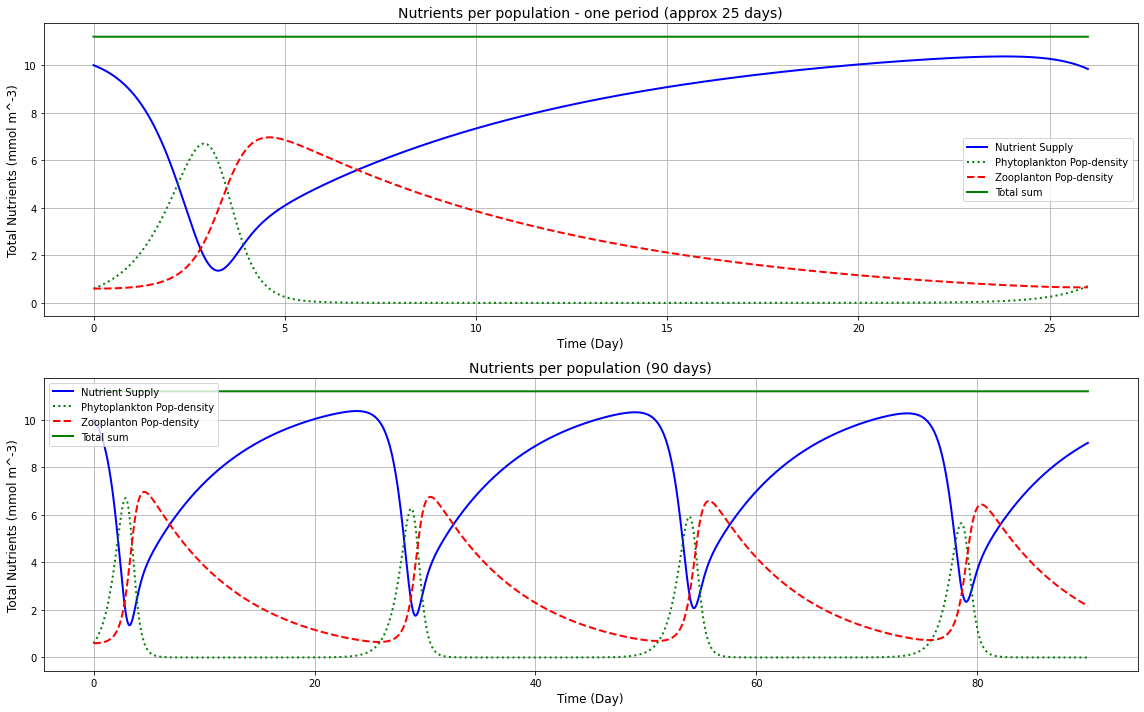

In [9]:
#Plot results
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#One cycle
ax.plot(sol.t, sol.y[0], 'b', linewidth= 2, label='Nutrient Supply')
ax.plot(sol.t, sol.y[1], 'g:', linewidth = 2, label='Phytoplankton Pop-density')
ax.plot(sol.t, sol.y[2], 'r--', linewidth = 2, label='Zooplanton Pop-density')

ax.plot(sol.t, sol.y[0]+sol.y[1]+sol.y[2], 'g', linewidth = 2, label='Total sum')

ax.set_xlabel('Time (Day)', fontsize = 12)
ax.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax.set_title('Nutrients per population - one period (approx 25 days)',fontsize = 14)
ax.legend()
ax.grid()

#Three Cycles
ax2.plot(cycle.t, cycle.y[0], 'b', linewidth= 2, label='Nutrient Supply')
ax2.plot(cycle.t, cycle.y[1], 'g:', linewidth = 2, label='Phytoplankton Pop-density')
ax2.plot(cycle.t, cycle.y[2], 'r--', linewidth = 2, label='Zooplanton Pop-density')

ax2.plot(cycle.t, cycle.y[0]+cycle.y[1]+cycle.y[2], 'g', linewidth = 2, label='Total sum')

ax2.set_xlabel('Time (Day)', fontsize = 12)
ax2.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax2.set_title('Nutrients per population (90 days)',fontsize = 14)
ax2.legend(loc='upper left')
ax2.grid()

fig.tight_layout()
plt.show()

In [10]:
#Finding the equalibrium of all state variables, assuming only one max and min.
state_vars = ["Nutrients", "Phytoplankton", "Zooplankton"]   
groups = {}

for i in range(3):
    solutions = cycle.y[i][4000:6000]
    
    max_y = np.max(solutions) #find max and min of each state variable 
    min_y = np.min(solutions)

    #Find time at which max and min happen (index placement)
    eq_max = np.where(solutions == max_y)[0][0]
    eq_min = np.where(solutions == min_y)[0][0]

    groups[state_vars[i] + '_max'] = [cycle.t[4000:6000][eq_max], cycle.y[0][4000:6000][eq_max], cycle.y[1][4000:6000][eq_max], cycle.y[2][4000:6000][eq_max]]
    groups[state_vars[i] + '_min'] = [cycle.t[4000:6000][eq_min], cycle.y[0][4000:6000][eq_min], cycle.y[1][4000:6000][eq_min], cycle.y[2][4000:6000][eq_min]]
    
    t_max = groups[state_vars[i] + '_max'][0]
    N_max = groups[state_vars[i] + '_max'][1]
    P_max = groups[state_vars[i] + '_max'][2]
    Z_max = groups[state_vars[i] + '_max'][3]
    
    t_min = groups[state_vars[i] + '_min'][0]
    N_min = groups[state_vars[i] + '_min'][1]
    P_min = groups[state_vars[i] + '_min'][2]
    Z_min = groups[state_vars[i] + '_min'][3]
                                      
    print("At max " + state_vars[i] + f": t = {t_max: .3f}, N = {N_max: .3f}, P = {P_max: .3f}, Z = {Z_max: .3f} ")
    print("At min " + state_vars[i] + f": t = {t_min: .3f}, N = {N_min: .3f}, P = {P_min: .3f}, Z = {Z_min: .3f} ")
    print()

At max Nutrients: t =  0.400, N =  9.685, P =  0.908, Z =  0.607 
At min Nutrients: t =  0.600, N =  9.468, P =  1.115, Z =  0.617 

At max Phytoplankton: t =  0.600, N =  9.468, P =  1.115, Z =  0.617 
At min Phytoplankton: t =  0.400, N =  9.685, P =  0.908, Z =  0.607 

At max Zooplankton: t =  0.600, N =  9.468, P =  1.115, Z =  0.617 
At min Zooplankton: t =  0.400, N =  9.685, P =  0.908, Z =  0.607 



In [11]:
# Defining equations
def gamma_P(N, K_N):
    '''Monod growth function for specified nutrient.
       return: Monod (flt)
    '''
    return N / (K_N + N)

def grazing_func(p_pop_den, z_pop_den, grazing_rate, half_sat):
    ''' Grazing function, assuming we are in the linear portion of 
        the monod feeding curve.
        
        return: portion of the phytoplankton population lost to grazing (flt)
    '''
    return grazing_rate * (p_pop_den / half_sat) * z_pop_den


def Gamma_P(pop_den, max_growth_rate, nutr_monod_func, mortality, grazing_func):
    ''' Population density of Phytoplankton over time (steady state)'''
    paren = max_growth_rate * nutr_monod_func - mortality - (grazing_func / pop_den)
    return pop_den * paren

def Gamma_Z(pop_den, growth_rate, grazing_func, mortality):
    ''' Population density of Zooplankton over time (steady state)'''
    paren = growth_rate * (grazing_func / pop_den) - mortality
    return pop_den * paren

def Gamma_N_closed(p_pop_den, max_growth, nutr_monod_func, p_mort,
           z_pop_den, z_assimilation, grazing_func, z_mort):
    
    '''Nutrient Supply Function'''
    
    from_phyto = p_pop_den * (-max_growth * nutr_monod_func + p_mort)
    
    from_zoo_paren = (1 - z_assimilation) * (grazing_func / z_pop_den) + z_mort
    from_zoo = z_pop_den * from_zoo_paren
    
    return from_phyto + from_zoo

In [12]:
#Double checking Nutrient values with state equations

N_max = groups[state_vars[0] + '_max'][1]
P_max = groups[state_vars[0] + '_max'][2]
Z_max = groups[state_vars[0] + '_max'][3]

N_min = groups[state_vars[0] + '_min'][1]
P_min = groups[state_vars[0] + '_min'][2]
Z_min = groups[state_vars[0] + '_min'][3]
  
gam_N_max = round(Gamma_N_closed(P_max, V_max, gamma_P(N_max, K_N), λ_P, Z_max, γ_Z, grazing_func(P_max, Z_max, g, K_P), λ_Z), 5)
gam_N_min = round(Gamma_N_closed(P_min, V_max, gamma_P(N_min, K_N), λ_P, Z_min, γ_Z, grazing_func(P_min, Z_min, g, K_P), λ_Z), 5)

print(f"Γ_N evaluates to {gam_N_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_N evaluates to {gam_N_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

#Double checking Phytoplankton values with state equations
N_max = groups[state_vars[1] + '_max'][1]
P_max = groups[state_vars[1] + '_max'][2]
Z_max = groups[state_vars[1] + '_max'][3]

N_min = groups[state_vars[1] + '_min'][1]
P_min = groups[state_vars[1] + '_min'][2]
Z_min = groups[state_vars[1] + '_min'][3]

gam_P_max = round(Gamma_P(P_max, V_max, gamma_P(N_max, K_N), λ_P, grazing_func(P_max, Z_max, g, K_P)), 5)
gam_P_min = round(Gamma_P(P_min, V_max, gamma_P(N_min, K_N), λ_P, grazing_func(P_min, Z_min, g, K_P)), 5)

print(f"Γ_P evaluates to {gam_P_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_P evaluates to {gam_P_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

#Double checking Zooplankton values with state equations
N_max = groups[state_vars[2] + '_max'][1]
P_max = groups[state_vars[2] + '_max'][2]
Z_max = groups[state_vars[2] + '_max'][3]

N_min = groups[state_vars[2] + '_min'][1]
P_min = groups[state_vars[2] + '_min'][2]
Z_min = groups[state_vars[2] + '_min'][3]

gam_Z_max = round(Gamma_Z(Z_max, γ_Z, grazing_func(P_max, Z_max, g, K_P), λ_Z), 5)
gam_Z_min = round(Gamma_Z(Z_min, γ_Z, grazing_func(P_min, Z_min, g, K_P), λ_Z), 5)

print(f"Γ_Z evaluates to {gam_Z_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_Z evaluates to {gam_Z_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

Γ_N evaluates to -0.97425 at the given values of N =  9.685, P =  0.908, and Z =  0.607
Γ_N evaluates to -1.20869 at the given values of N =  9.468, P =  1.115, and Z =  0.617

Γ_P evaluates to 1.14514 at the given values of N =  9.468, P =  1.115, and Z =  0.617
Γ_P evaluates to 0.93691 at the given values of N =  9.685, P =  0.908, and Z =  0.607

Γ_Z evaluates to 0.06356 at the given values of N =  9.468, P =  1.115, and Z =  0.617
Γ_Z evaluates to 0.03734 at the given values of N =  9.685, P =  0.908, and Z =  0.607

